<a href="https://colab.research.google.com/github/vektor8891/llm/blob/main/projects/18_adapters_pytorch/18_adapters_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torchtext==0.17.2
# !pip install torchdata==0.7.1
# !pip install portalocker==2.8.2

# Adapters in PyTorch

- Adapters: one technique for parameter efficient fine-tuning (PEFT)
- Adapters enable modular training within the model without changing the pre-existing pretrained parameters

## Define helper functions

In [2]:
import matplotlib.pyplot as plt
import pickle


def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

# Positional encodings

In [3]:
import torch
torch.set_num_threads(1)
from torch import nn
import math


class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

# Import IMDB data set

In [4]:
from urllib.request import urlopen
import io
import tarfile
import tempfile


urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

In [5]:
from torch.utils.data import Dataset
import os


class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: The base directory of the IMDB dataset.
        train: A boolean flag indicating whether to use training or test data.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return label, content

In [6]:
root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # For training data
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # For test data

start=train_iter.pos_inx
for i in range(-10,10):
    print(train_iter[start+i])

(0, 'THHE remake was a superior movie remake in every way. Most remakes end up being total garbage but under the very talented direction of Alexandre Aja became one of the best ever made in terms of remakes and also as far as the mutant inbreed human sub-genre of horror is concerned. In steps part 2 directed by another individual Martin Weisz and written by the father and son combo of Jonathan and Wes "I cannot make a good horror movie to save my life anymore" Craven and if this is any indication of Weisz directing skills and young Craven\'s writing skills we are all in for a painful future as THHE 2 not only fails to be as good as the first but also fails to entertain on ANY level.<br /><br />We start off with a fairly graphic mutant baby birth which though is rather cool will not prepare you for the utter garbage that is to come, only hint to what could have been in this film. We then get to see a crew of scientists who all to briefly are introduced and dispatched by our radiated rej

In [7]:
imdb_label = {0: " negative review", 1: "positive review"}
imdb_label[1]

'positive review'

In [8]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

In [9]:
from torchtext.data.utils import get_tokenizer


tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    """Yield tokens for each data sample."""
    for _, text in data_iter:
        yield tokenizer(text)

In [10]:
from torchtext.vocab import GloVe, Vectors


# Note that GloVe embeddings are typically downloaded using:
#glove_embedding = GloVe(name="6B", dim=100)
# However, the GloVe server is frequently down. The code below offers a workaround


class GloVe_override(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        #name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override, self).__init__(name, url=url, **kwargs)

class GloVe_override2(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        #name = "glove.{}.{}d.txt".format(name, str(dim))
        name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override2, self).__init__(name, url=url, **kwargs)

try:
    glove_embedding = GloVe_override(name="6B", dim=100)
except:
    try:
        glove_embedding = GloVe_override2(name="6B", dim=100)
    except:
        glove_embedding = GloVe(name="6B", dim=100)

.vector_cache/glove-6B.zip: 134MB [00:01, 77.8MB/s]                          
100%|█████████▉| 399999/400000 [00:22<00:00, 17698.58it/s]


In [11]:
from torchtext.vocab import vocab

# Build vocab from glove_vectors
vocab = vocab(glove_embedding .stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [12]:
vocab_size=len(vocab)
vocab_size

400002

In [13]:
vocab(['he'])

[20]

### Data set splits

In [14]:
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data.dataset import random_split


# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [15]:
num_train = int(len(train_dataset) * 0.05)
split_train_, _ = random_split(split_train_, [num_train, len(split_train_) - num_train])

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader


In [17]:
def text_pipeline(x):
    return vocab(tokenizer(x))

In [18]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:

        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)

    return label_list.to(device), text_list.to(device)

In [19]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

### Neural network


In [20]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """
    def __init__(

        self,
        num_class,vocab_size,
        freeze=True,
        nhead=2,
        dim_feedforward=128,
        num_layers=2,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        #self.emb = embedding=nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        self.emb = nn.Embedding.from_pretrained(glove_embedding.vectors,freeze=freeze)
        embedding_dim = self.emb.embedding_dim


        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(num_class=2,vocab_size=vocab_size).to(device)
model

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

In [22]:
def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        model.to(device)
        output = model(text)
        return imdb_label[output.argmax(1).item()]

In [23]:
predict("I like sports and stuff", text_pipeline, model)

'positive review'

In [24]:
from tqdm import tqdm


def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in tqdm(dataloader):
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [25]:
def evaluate_no_tqdm(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            output = model_eval(text)
            predicted = torch.max(output.data, 1)[1]
            total_acc += (predicted == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [26]:
#evaluate(test_dataloader, model)

# Training

In [60]:
import time

def train_model(model, optimizer, criterion, train_dataloader, valid_dataloader,  epochs=1000, save_dir="", file_name=None):
    cum_loss_list = []
    acc_epoch = []
    acc_old = 0
    model_path = os.path.join(save_dir, file_name)
    acc_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_acc")
    loss_dir = os.path.join(save_dir, os.path.splitext(file_name)[0] + "_loss")
    time_start = time.time()

    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        #print(model)
        #for parm in model.parameters():
        #    print(parm.requires_grad)

        cum_loss = 0
        for idx, (label, text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            label, text = label.to(device), text.to(device)

            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            #print(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        print(f"Epoch {epoch}/{epochs} - Loss: {cum_loss}")

        cum_loss_list.append(cum_loss)
        accu_val = evaluate_no_tqdm(valid_dataloader,model)
        acc_epoch.append(accu_val)

        if model_path and accu_val > acc_old:
            print(accu_val)
            acc_old = accu_val
            if save_dir is not None:
                pass
                #print("save model epoch",epoch)
                #torch.save(model.state_dict(), model_path)
                #save_list_to_file(lst=acc_epoch, filename=acc_dir)
                #save_list_to_file(lst=cum_loss_list, filename=loss_dir)

    time_end = time.time()
    print(f"Training time: {time_end - time_start}")

In [28]:
# LR=1
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
# save_dir = ""
# file_name = "model_IMDB dataset small2.pth"
# train_model(model=model,
#             optimizer=optimizer,
#             criterion=criterion,
#             train_dataloader=train_dataloader,
#             valid_dataloader=valid_dataloader,
#             epochs=2,
#             save_dir=save_dir,
#             file_name=file_name
#            )

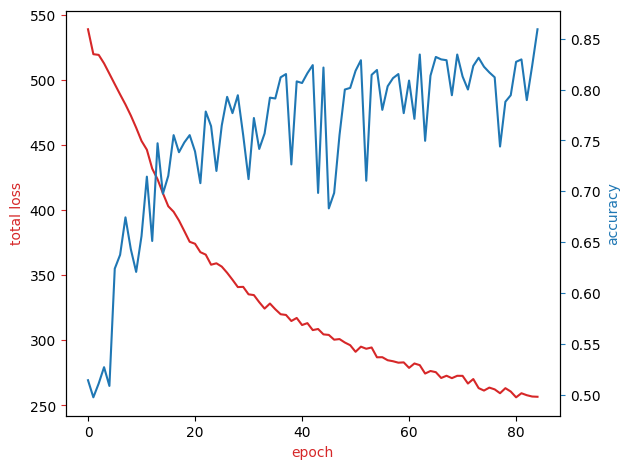

In [29]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/sybqacL5p1qeEO8d4xRZNg/model-IMDB%20dataset%20small2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/eOt6woGoaOB565T0RLH5WA/model-IMDB%20dataset%20small2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [30]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/q66IH6a7lglkZ4haM6hB1w/model-IMDB%20dataset%20small2.pth')
model_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader, model_)

<All keys matched successfully>

### Fine-tune a model pretrained on the AG News data set

In [31]:
from torchtext.datasets import AG_NEWS


train_iter_ag_news = AG_NEWS(split="train")

num_class_ag_news = len(set([label for (label, text) in train_iter_ag_news ]))
num_class_ag_news

# Split the dataset into training and testing iterators.
train_iter_ag_news, test_iter_ag_news = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset_ag_news = to_map_style_dataset(train_iter_ag_news)
test_dataset_ag_news = to_map_style_dataset(test_iter_ag_news)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train_ag_news = int(len(train_dataset_ag_news) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_ag_news_, split_valid_ag_news_ = random_split(train_dataset_ag_news, [num_train_ag_news, len(train_dataset_ag_news) - num_train_ag_news])

# Make the training set smaller to allow it to run fast as an example.
# IF YOU WANT TO TRAIN ON THE AG_NEWS DATASET, COMMENT OUT THE 2 LINEs BELOW.
# HOWEVER, NOTE THAT TRAINING WILL TAKE A LONG TIME
num_train_ag_news = int(len(train_dataset_ag_news) * 0.05)
split_train_ag_news_, _ = random_split(split_train_ag_news_, [num_train_ag_news, len(split_train_ag_news_) - num_train_ag_news])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

def label_pipeline(x):
   return int(x) - 1

from torch.nn.utils.rnn import pad_sequence

def collate_batch_ag_news(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

BATCH_SIZE = 32

train_dataloader_ag_news = DataLoader(
    split_train_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
valid_dataloader_ag_news = DataLoader(
    split_valid_ag_news_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)
test_dataloader_ag_news = DataLoader(
    test_dataset_ag_news, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_ag_news
)


model_ag_news = Net(num_class=4,vocab_size=vocab_size).to(device)
model_ag_news.to(device)

# ### Uncomment to Train ###
# LR=1
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model_ag_news.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
# save_dir = ""
# file_name = "model_AG News small1.pth"
# train_model(model=model_ag_news, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader_ag_news, valid_dataloader=valid_dataloader_ag_news,  epochs=2, save_dir=save_dir, file_name=file_name)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=4, bias=True)
)

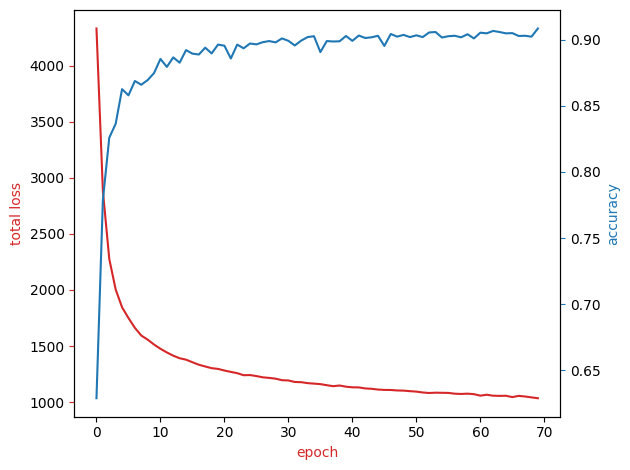

In [32]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bQk8mJu3Uct3I4JEsEtRnw/model-AG%20News%20small1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KNQkqJWWwY_XfbFBRFhZNA/model-AG%20News%20small1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [33]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_ag_news_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_ag_news_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader_ag_news, model_ag_news_)

<All keys matched successfully>

In [34]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine1 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine1.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

<All keys matched successfully>

In [35]:
model_fine1.classifier
in_features = model_fine1.classifier.in_features
print("Original final layer:", model_fine1.classifier)
print("Input dimention  final layer:", in_features)

Original final layer: Linear(in_features=100, out_features=4, bias=True)
Input dimention  final layer: 100


In [36]:
model_fine1.classifier = nn.Linear(in_features, 2)
model_fine1.to(device)

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

In [37]:
for name, param in model_fine1.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

emb.weight requires_grad: False
transformer_encoder.layers.0.self_attn.in_proj_weight requires_grad: True
transformer_encoder.layers.0.self_attn.in_proj_bias requires_grad: True
transformer_encoder.layers.0.self_attn.out_proj.weight requires_grad: True
transformer_encoder.layers.0.self_attn.out_proj.bias requires_grad: True
transformer_encoder.layers.0.linear1.weight requires_grad: True
transformer_encoder.layers.0.linear1.bias requires_grad: True
transformer_encoder.layers.0.linear2.weight requires_grad: True
transformer_encoder.layers.0.linear2.bias requires_grad: True
transformer_encoder.layers.0.norm1.weight requires_grad: True
transformer_encoder.layers.0.norm1.bias requires_grad: True
transformer_encoder.layers.0.norm2.weight requires_grad: True
transformer_encoder.layers.0.norm2.bias requires_grad: True
transformer_encoder.layers.1.self_attn.in_proj_weight requires_grad: True
transformer_encoder.layers.1.self_attn.in_proj_bias requires_grad: True
transformer_encoder.layers.1.sel

In [38]:
# LR=1
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model_fine1.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
# save_dir = ""
# file_name = "model_fine1.pth"
# train_model(model=model_fine1, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

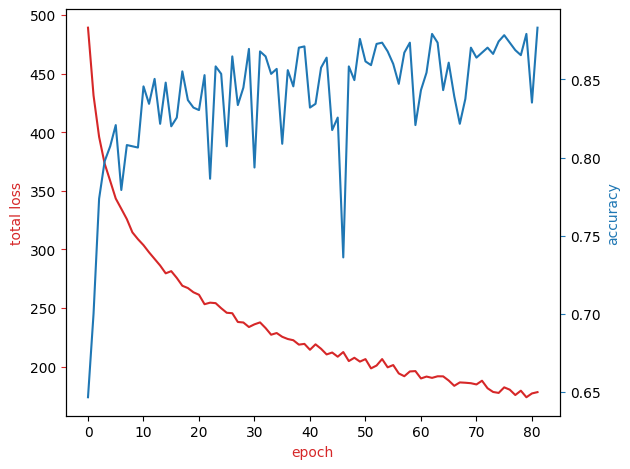

In [39]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/3LEJw8BRgJJFGqlLxaETxA/model-fine1-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/-CT1h97vjv0TolY82Nw29g/model-fine1-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [40]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/e0WOHKh5dnrbC2lGhpsMMw/model-fine1.pth')
model_fine1_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine1_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader, model_fine1_)

<All keys matched successfully>

### Fine-tune the final layer only

In [41]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_fine2 = Net(vocab_size=vocab_size, num_class=4).to(device)
model_fine2.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

<All keys matched successfully>

In [42]:
# Freeze all layers in the model
for param in model_fine2.parameters():
    param.requires_grad = False

In [43]:
dim=model_fine2.classifier.in_features
model_fine2.classifier = nn.Linear(dim, 2)
model_fine2.to(device)

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=2, bias=True)
)

In [44]:
# LR=1
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model_fine2.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
# save_dir = ""
# file_name = "model_fine2.pth"
# train_model(model=model_fine2, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name)

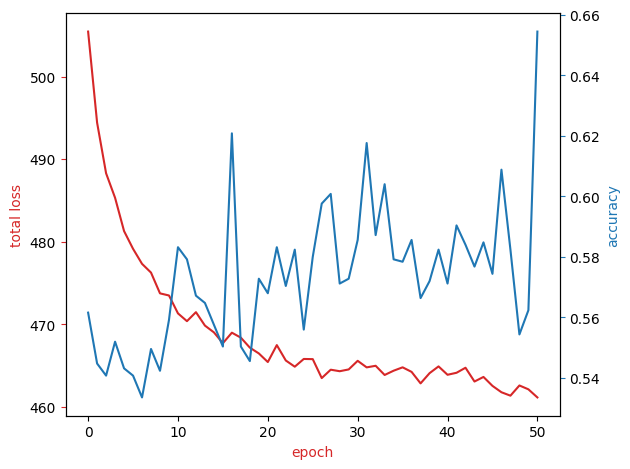

In [45]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UdR3ApQnxSeV2mrA0CbiLg/model-fine2-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rWGDIF-uL2dEngWcIo9teQ/model-fine2-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [46]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/B-1H6lpDg-A0zRwpB6Ek2g/model-fine2.pth')
model_fine2_ = Net(vocab_size=vocab_size, num_class=2).to(device)
model_fine2_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
#evaluate(test_dataloader, model_fine2_)

<All keys matched successfully>

# Adapters

- Adapter: neural network module; low-dimensional bottleneck in transformer architecture to allow fine-tuning with fewer parameters.
- Steps:
  1. compresses original high-dimensional embeddings into a lower dimension,
  2. applies non-linear transformation,
  3. expands back to original dimension.

In [48]:
class FeatureAdapter(nn.Module):
    """
    Attributes:
        size (int): The bottleneck dimension to which the embeddings are temporarily reduced.
        model_dim (int): The original dimension of the embeddings or features in the transformer model.
    """
    def __init__(self, bottleneck_size=50, model_dim=100):
        super().__init__()
        self.bottleneck_transform = nn.Sequential(
            nn.Linear(model_dim, bottleneck_size),  # Down-project to a smaller dimension
            nn.ReLU(),                             # Apply non-linearity
            nn.Linear(bottleneck_size, model_dim)  # Up-project back to the original dimension
        )

    def forward(self, x):
        """
        Forward pass of the FeatureAdapter. Applies the bottleneck transformation to the input
        tensor and adds a skip connection.

        Args:
            x (Tensor): Input tensor with shape (batch_size, seq_length, model_dim).

        Returns:
            Tensor: Output tensor after applying the adapter transformation and skip connection,
                    maintaining the original input shape.
        """
        transformed_features = self.bottleneck_transform(x)  # Transform features through the bottleneck
        output_with_residual = transformed_features + x      # Add the residual connection
        return output_with_residual

In [49]:
class Adapted(nn.Module):
    def __init__(self, linear,bottleneck_size=None):
        super(Adapted, self).__init__()
        self.linear = linear
        model_dim = linear.out_features
        if bottleneck_size is None:
          bottleneck_size = model_dim//2   # Define default bottleneck size as half the model_dim

        # Initialize FeatureAdapter with calculated bottleneck_size and model_dim
        self.adaptor = FeatureAdapter(bottleneck_size=bottleneck_size, model_dim=model_dim)

    def forward(self, x):
        # First, the input x is passed through the linear layer
        x=self.linear(x)
        # Then it's adapted using FeatureAdapter
        x= self.adaptor(x)
        return x

In [50]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9c3Dh2O_jsYBShBuchUNlg/model-AG%20News%20small1.pth')
model_adapters = Net(vocab_size=vocab_size, num_class=4).to(device)
model_adapters.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))

<All keys matched successfully>

In [51]:
for param in model_adapters.parameters():
    param.requires_grad = False

dim= model_adapters.classifier.in_features
model_adapters.classifier = nn.Linear(dim, 2)

In [52]:
my_example_layer=model_adapters.transformer_encoder.layers[0].linear1
print(my_example_layer)

Linear(in_features=100, out_features=128, bias=True)


In [53]:
my_adapeted_layer=Adapted(my_example_layer)
print(my_adapeted_layer)

Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
    )
  )
)


In [54]:
for parm in my_adapeted_layer.parameters():
    print(parm.requires_grad)

False
False
True
True
True
True


In [55]:
# Find number of layers
N_layers=len(model_adapters.transformer_encoder.layers)

In [56]:
# Traverse model and adapt
for n in range(N_layers):
  encoder=model_adapters.transformer_encoder.layers[n]
  if encoder.linear1:
    print(" before linear1")
    print(encoder.linear1)
    model_adapters.transformer_encoder.layers[n].linear1=Adapted(encoder.linear1, bottleneck_size=24)
    print(" after  linear1")
    print(model_adapters.transformer_encoder.layers[n].linear1)

  if encoder.linear2:
    print(" before linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)
    model_adapters.transformer_encoder.layers[n].linear2=Adapted(encoder.linear2, bottleneck_size=24)
    print(" after linear2")
    print(model_adapters.transformer_encoder.layers[n].linear2)

 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=128, bias=True)
    )
  )
)
 before linear2
Linear(in_features=128, out_features=100, bias=True)
 after linear2
Adapted(
  (linear): Linear(in_features=128, out_features=100, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=100, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=100, bias=True)
    )
  )
)
 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
     

In [57]:
# Send model to device
model_adapters.to(device)

Net(
  (emb): Embedding(400000, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Adapted(
          (linear): Linear(in_features=100, out_features=128, bias=True)
          (adaptor): FeatureAdapter(
            (bottleneck_transform): Sequential(
              (0): Linear(in_features=128, out_features=24, bias=True)
              (1): ReLU()
              (2): Linear(in_features=24, out_features=128, bias=True)
            )
          )
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Adapted(
          (linear): Linear(in_features=128, out_features=100, bias=True)
          (adaptor): FeatureAdapter(
            (bottleneck_transform): 

In [61]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_adapters.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
save_dir = ""
file_name = "model_adapters.pth"
train_model(model=model_adapters, optimizer=optimizer, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,  epochs=2,  save_dir=save_dir ,file_name=file_name )

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Loss: 27.617043793201447


 50%|█████     | 1/2 [01:00<01:00, 60.29s/it]

0.5168
Epoch 2/2 - Loss: 28.043482542037964


100%|██████████| 2/2 [01:54<00:00, 57.39s/it]

0.576
Training time: 114.78885006904602


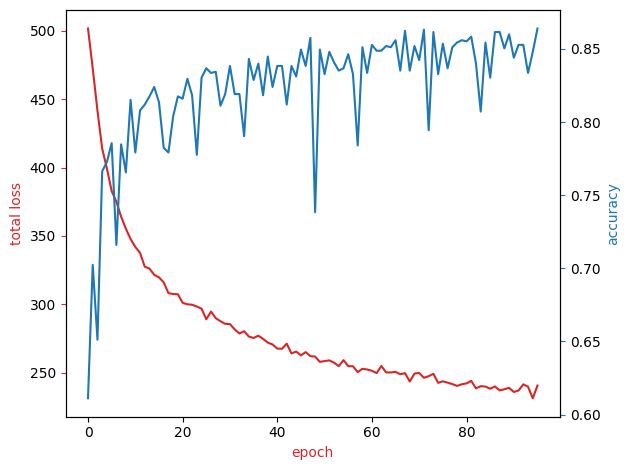

In [62]:
acc_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/D49zrrMPWO_ktwQo7PSHIQ/model-adapters-acc')
loss_urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RXWlmyaco695RiaoU7QsnA/model-adapters-loss')
acc_epoch = pickle.load(acc_urlopened)
cum_loss_list = pickle.load(loss_urlopened)
plot(cum_loss_list,acc_epoch)

In [63]:
model_adapters_ = Net(vocab_size=vocab_size, num_class=2).to(device)
for n in range(N_layers):
  encoder=model_adapters_.transformer_encoder.layers[n]
  if encoder.linear1:
    print(" before linear1")
    print(encoder.linear1)
    model_adapters_.transformer_encoder.layers[n].linear1=Adapted(encoder.linear1, bottleneck_size=24)
    print(" after  linear1")
    print(model_adapters_.transformer_encoder.layers[n].linear1)

  if encoder.linear2:
    print(" before linear2")
    print(model_adapters_.transformer_encoder.layers[n].linear2)
    model_adapters_.transformer_encoder.layers[n].linear2=Adapted(encoder.linear2, bottleneck_size=24)
    print(" after linear2")
    print(model_adapters_.transformer_encoder.layers[n].linear2)

model_adapters_.to(device)
for param in model_adapters_.parameters():
    param.requires_grad = False

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/PGhd5G_NVrWNH-_jdjwNlw/model-adapters.pth')
model_adapters_.load_state_dict(torch.load(io.BytesIO(urlopened.read()), map_location=device))
evaluate(test_dataloader, model_adapters_)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=128, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=128, bias=True)
    )
  )
)
 before linear2
Linear(in_features=128, out_features=100, bias=True)
 after linear2
Adapted(
  (linear): Linear(in_features=128, out_features=100, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
      (0): Linear(in_features=100, out_features=24, bias=True)
      (1): ReLU()
      (2): Linear(in_features=24, out_features=100, bias=True)
    )
  )
)
 before linear1
Linear(in_features=100, out_features=128, bias=True)
 after  linear1
Adapted(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (adaptor): FeatureAdapter(
    (bottleneck_transform): Sequential(
     

100%|██████████| 782/782 [05:19<00:00,  2.45it/s]


0.85736

## Exercise: Adapt linear layers in a different network

In [64]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

exercise_model = NeuralNetwork()

exercise_model.to(device)
for param in exercise_model.parameters():
    param.requires_grad = False

print(exercise_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [65]:
exercise_model.linear_relu_stack[0] = Adapted(exercise_model.linear_relu_stack[0], bottleneck_size=30)
exercise_model.linear_relu_stack[2] = Adapted(exercise_model.linear_relu_stack[2], bottleneck_size=30)
exercise_model.linear_relu_stack[4] = nn.Linear(512, 5)
print(exercise_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Adapted(
      (linear): Linear(in_features=784, out_features=512, bias=True)
      (adaptor): FeatureAdapter(
        (bottleneck_transform): Sequential(
          (0): Linear(in_features=512, out_features=30, bias=True)
          (1): ReLU()
          (2): Linear(in_features=30, out_features=512, bias=True)
        )
      )
    )
    (1): ReLU()
    (2): Adapted(
      (linear): Linear(in_features=512, out_features=512, bias=True)
      (adaptor): FeatureAdapter(
        (bottleneck_transform): Sequential(
          (0): Linear(in_features=512, out_features=30, bias=True)
          (1): ReLU()
          (2): Linear(in_features=30, out_features=512, bias=True)
        )
      )
    )
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)


In [66]:
!pip freeze > requirements.txt